In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print(tf.__version__)


2.3.0


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(dataset_dir)
print(os.listdir(dataset_dir))

train_dir = os.path.join(dataset_dir, 'train')

print(os.listdir(train_dir))

84131840/84125825 [==============================] - 11s 0us/step

In [4]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
print(remove_dir)
shutil.rmtree(remove_dir)

./aclImdb/train/unsup


In [12]:
batch_size=32
seed=42

raw_train_ds=tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)
# 官方文档对这个方法的输出有说明
# it yields a tuple (texts, labels), where texts has shape (batch_size,)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
for text_batch,label_batch in raw_train_ds.take(1):#take了1个batch
    for i in range(3):
        print('Review',text_batch.numpy()[i])
        print('label',label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [18]:
count=0
pos_dir = os.path.join(dataset_dir, 'train/pos')
print(len(os.listdir(pos_dir)))
neg_dir = os.path.join(dataset_dir, 'train/neg')
print(len(os.listdir(neg_dir)))

for text_batch,label_batch in raw_train_ds:
    count+=1
print(count)

12500
12500
625


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [14]:
def custom_standardization(input_data):
    print(input_data) #Tensor("args_0:0", shape=(None, 1), dtype=string)所以说传入的是一个batch
    print(type(input_data))
    print(input_data.dtype) # input_data就是一个batch，其中每个元素是一行文字，一个文字序列

    lowercase=tf.strings.lower(input_data)
    stripped_html=tf.strings.regex_replace(lowercase,'<br />', ' ')
    return tf.strings.regex_replace(stripped_html,'[%s]'%re.escape(string.punctuation),'')

In [15]:
max_features=10000 #词表大小
sequence_length=250 #对过长的序列截断，对短序列补0
vectorize_layer=TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

#It transforms a batch of strings (one sample = one string) into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens).
# 所以这个方法是对a batch of strings进行处理
# 丢与custom_standardization的规范，官方api里写的很清楚，
# 对verctorize_layer的输入是[["string to split"], ["another string to split"]]这个形式的
# 但是对于custom_layers，在split的时候看到的是["string to split", "another string to split"]
# 看文档吧

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x) # 所以这里的train_text中每个元素是a string tensors of shape (batch_size,)
for text_batch in train_text.take(1):
    print(text_batch)
    for i in range(2):
        print(text_batch[i])
vectorize_layer.adapt(train_text) #相当于构建词表字典

<class 'tensorflow.python.framework.ops.Tensor'>
<dtype: 'string'>


In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1) 
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
it=iter(raw_train_ds)

text_batch, label_batch = next(it)
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

text_batch, label_batch = next(it)
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up.", shape=(), dtype=string)
Label pos
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'string'>
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 253,  105,   88,    5,    1,    1,   94,   10,   68,  131,   12,
          11,    7,   24,  113,   19,    6, 1290,    3,    2,   88, 1603,
          29,    4, 2216, 2674,  84

In [38]:
import numpy as np
words_max=0
for text_batch,label_batch in raw_train_ds:
    for review in text_batch:
        word_vector,_=vectorize_text(review, None)
        temp=np.max(word_vector.numpy()[0])
        words_max=words_max if words_max>temp else temp
words_max #9999，也就是大小为10000的词表

9999

In [66]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [18]:
no_exp_train_ds = raw_train_ds.map(lambda text_b,label_b:(vectorize_layer(text_b),label_b))
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


<class 'tensorflow.python.framework.ops.Tensor'>
<dtype: 'string'>
<class 'tensorflow.python.framework.ops.Tensor'>
<dtype: 'string'>
<class 'tensorflow.python.framework.ops.Tensor'>
<dtype: 'string'>


In [ ]:
print(no_exp_train_ds)
for text_batch,label_batch in no_exp_train_ds.take(1):
    print(text_batch.shape)
    for i in range(2):
        print(text_batch[i])

print(train_ds)
for text_batch,label_batch in train_ds.take(1):
    print(text_batch.shape)
    for i in range(2):
        print(text_batch[i])

# 可以看出上面两个东西实际是相同的，他们的差别也就是是否执行tf.expand_dims(text, -1)
# vectorize_layer接受的输入是一个(batch_size,1)或者(batch_size,)的tensor
# 而raw_train_ds的每个元素刚好是一个tuple，其中tuple的第一个元素就满足(batch_size,)
# tutorial之中为了能展示其中一条的序列化信息，如下
# first_review, first_label = text_batch[0], label_batch[0]
# first_review只是一个shape=()的tensor，所以要扩展成一个shape=(1)的tensor


可以看出上面两个东西实际是相同的，他们的差别也就是是否执行tf.expand_dims(text, -1)
vectorize_layer接受的输入是一个(batch_size,1)或者(batch_size,)的tensor
irst_review, first_label = text_batch[0], label_batch[0]


In [19]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
embedding_dim=16
model=tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),#第一个维度是样本维度，之后就是特征维度，由于每个输入是一串文字，所以是一个250*16的矩阵，在第二维度进行pooling
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
history=model.fit(
    train_ds,validation_data=val_ds,epochs=10
)

Epoch 1/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6649 - binary_accuracy: 0.6921 - val_loss: 0.6167 - val_binary_accuracy: 0.7730

In [25]:
y_pre=model(next(iter(test_ds))[0])

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

print(y_pre)

782/782 [==============================] - 1s 647us/step - loss: 0.3099 - binary_accuracy: 0.8740

In [88]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

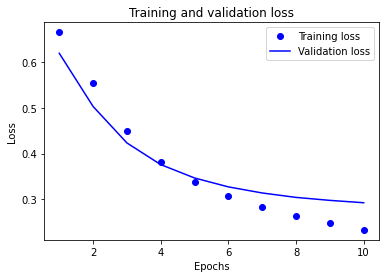

In [89]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

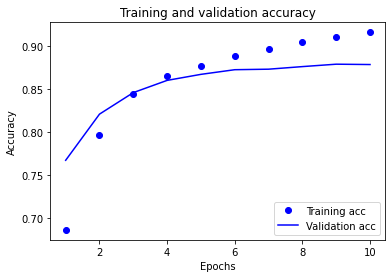

In [90]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [26]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
# softmax之前的输出，就是logits

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

<class 'tensorflow.python.framework.ops.Tensor'>
<dtype: 'string'>
<class 'tensorflow.python.framework.ops.Tensor'>
<dtype: 'string'>
<class 'tensorflow.python.framework.ops.Tensor'>
<dtype: 'string'>
782/782 [==============================] - 3s 4ms/step - loss: 0.3099 - accuracy: 0.8740